### Bibliotecas

In [2]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from numba import jit

### Funções

In [3]:

# Receber imagem Original
# Mudar para tons de cinza

def image_to_gray(image):
    image_gray = np.zeros((len(image), len(image[0])),dtype=np.uint8)

    for i in range(len(image)):
        for j in range(len(image[0])):
            image_gray[i][j] = (int( image[i][j][0] )+ int(image[i][j][1] )+ int(image[i][j][2] ) )/ len(image[0][0])
    
    return image_gray


# Recebe em tons de cinza
# Colocar Borda na imagem

def zero_box(image, kernel=3):

    var = int((kernel - 1) / 2)
    mask_zeros = np.zeros((len(image) + kernel - 1, len(image[0]) + kernel - 1), dtype=np.uint8) # cria a borda de zeros
    mask_zeros[var:len(image) + var, var:len(image[0]) + var] = image # sobrepoe a imagem sentralizada na matriz

    return mask_zeros


# Recebe a Imagem com as bordas
# Cria a Lista de Kernels

def slice_image(image_in_box, kernel):

    borda = int((kernel-1)/2) 

    input_blur = image_in_box

    var  = kernel - borda

    slice_list = []

    for i in range(len(image_in_box)): #linhas 
        for j in range(len(image_in_box[0])): #colunas

            if (i >= borda and i < (len(image_in_box) -borda))  and ( j >= borda and j < len(image_in_box[0]) -borda):

                slice = image_in_box[i-borda:i+var, j-borda:j+var]

                slice_list.append(slice)
                
    return slice_list

# Recebe a Lista de Kernels
# Gerar a Lista dos cálculos

def calc_slice_averages(slice_list):
    
    results = []
    for i in slice_list:
        average = np.mean(i)
        results.append(average)
    return results


def ver_slice_white(slice_list):
    results = []
    for i in slice_list:
        average = np.mean(i)
        if average < 255:
            results.append(0)
        else:
            results.append(255)

    return results

def ver_slice_black(slice_list):
    results = []
    for i in slice_list:
        average = np.mean(i)
        if average > 0:
            results.append(255)
        else:
            results.append(0)

    return results

def calc_grad_morf(dilat, erode):
    m_suporte = np.zeros((len(dilat), len(dilat[0])),dtype=np.uint8)

    for i in range(len(m_suporte)): #linhas 
        for j in range(len(m_suporte[0])): #colunas
               m_suporte[i][j] =int(dilat[i][j]-erode[i][j])

    return m_suporte


# Recebe a Lista de Valores - subtrai a constante c
# Retornar ums nova imagem nas dimensões da original
def build_thresh_adapt(results,image, c):
    '''
    entrar com imagem já inserida em uma matriz com bordas 
    kernel determina a borda da imagem

    retorna o resultado com as bordas da matriz
    '''
    adapted_image = np.array(results).reshape(image.shape).astype(np.uint8)

    m_suporte = np.zeros((len(image), len(image[0])),dtype=np.uint8)

    for i in range(len(m_suporte)):
        for j in range(len(m_suporte[0])):

            if image[i][j]< adapted_image[i][j] - c:
                m_suporte[i][j] = 0
            else:
                m_suporte[i][j] = 255

    return m_suporte

# Recebe a Lista de Valores
# Retornar ums nova imagem nas dimensões da original

def build_image(results,image):
    
    blurred_image = np.array(results).reshape(image.shape).astype(np.uint8)

    return blurred_image

# receber imagem em tons de cinza
# retornar imagem limiarizada

def image_threshold(image, limiar):
   
    input_limiar = np.zeros((len(image), len(image[0])),dtype=np.uint8)

    for i in range(len(image)):
        for j in range(len(image[0])):

            if image[i][j] <= limiar:
                input_limiar[i][j] = 0
            else:
                input_limiar[i][j] = 255
                
    return input_limiar



def histogram_weight(imagem):
    
    lista = plt.hist(imagem.ravel(),256,[0,256])
    plt.clf()
    # Set minimum value to infinity
    final_min = np.inf
    # total pixels in an image
    total = np.sum(lista[0])
    for i in range(256):
        # Split regions based on threshold
        left, right = np.hsplit(lista[0],[i])
        # Splt intensity values based on threshold
        left_bins, right_bins = np.hsplit(lista[1],[i])
        # Only perform thresholding if neither side empty
        if np.sum(left) !=0 and np.sum(right) !=0:
            # Calculate weights on left and right sides
            w_0 = np.sum(left)/total
            w_1 = np.sum(right)/total
            # Calculate the mean for both sides
            mean_0 = np.dot(left,left_bins)/np.sum(left)
            mean_1 = np.dot(right,right_bins[:-1])/np.sum(right)  # right_bins[:-1] because matplotlib has uses 1 bin extra
            # Calculate variance of both sides
            var_0 = np.dot(((left_bins-mean_0)**2),left)/np.sum(left)
            var_1 = np.dot(((right_bins[:-1]-mean_1)**2),right)/np.sum(right)
            # Calculate final within class variance
            final = w_0*var_0 + w_1*var_1
            # if variance minimum, update it
            if final<final_min:
                final_min = final
                thresh = i

    return thresh





def process_blur(gray_image,k):
    
    # tonsdecinza = image_to_gray(image)
    box = zero_box(gray_image,k)
    fatias = slice_image(box,k)
    listademediasdaimagem = calc_slice_averages(fatias)
    blur_slice = build_image(listademediasdaimagem,gray_image)
    return blur_slice

def process_lim_fix(image_gray, l):
    
    fixed_limiarized_imsage = image_threshold(image_gray,l)

    return fixed_limiarized_imsage


def process_lim_adapt(image_gray, k, const_c):

    # inserir borda
    box = zero_box(image_gray,k)
    # Gerar os kernels de cálculo
    kernels = slice_image(box, k)
    # Calcular
    kern_calc_c = calc_slice_averages(kernels)
    # construir uma nova imagem
    adapt_limiarized_imsage = build_thresh_adapt(kern_calc_c,image_gray, const_c)

    return adapt_limiarized_imsage


def process_lim_otsu(tonsdecinza):

    limiar_o = histogram_weight(tonsdecinza)
    image_o = image_threshold(tonsdecinza , limiar_o)

    return image_o


def process_erode_image(otsu_tre, k):

    # inserir borda
    box = zero_box(otsu_tre,k)
    # Gerar os kernels de cálculo
    kernels = slice_image(box, k)
    # verificar os kernels
    list_results = ver_slice_white(kernels)
    # construir imagem
    erode = build_image(list_results,otsu_tre)
    
    return erode

def process_dilate_image(otsu_tre, k):

    # inserir borda
    box = zero_box(otsu_tre,k)
    # Gerar os kernels de cálculo
    kernels = slice_image(box, k)
    # verificar os kernels
    list_results = ver_slice_black(kernels)
    # construir imagem
    erode = build_image(list_results,otsu_tre)
    
    return erode

def process_opening_image(otsu_tre, k):
    # Erosão
    erode = process_erode_image(otsu_tre, k)
    # Dilatação
    oppening = process_dilate_image(erode, k)
    return oppening

def process_closing_image(otsu_tre, k):
    # Dilatação
    dilate = process_dilate_image(otsu_tre, k)
    # Erosão
    close = process_erode_image(dilate, k)

    return close

def process_grad_morf_image(otsu_tre, k):
    # Erosão
    erode = process_erode_image(otsu_tre, k)
    # Dilatação
    dilat = process_dilate_image(otsu_tre, k)

    g_morf = calc_grad_morf(dilat, erode)

    return g_morf

def process_cartol_image(image_threshold,k):
    ''' Diferença entre Imagem de entrada e a Abertura '''
    open_image = process_opening_image(image_threshold, k)
    cartol = calc_grad_morf(image_threshold, open_image)

    return cartol

def process_darkhat_image(image_threshold,k):
    ''' Diferença eentre a imagem de entrada e o Fechamento'''
    close_image = process_closing_image(image_threshold, k)
    darkhat = calc_grad_morf(close_image, image_threshold)

    return darkhat


### Input dos dados

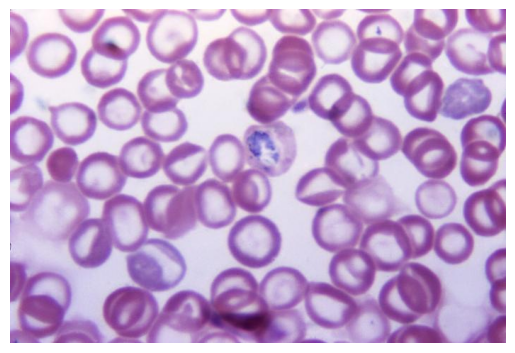

 largura 700 altura 471  em pixels canais 3 


In [32]:

imagem_placa = cv2.imread('cell.jpg')
imagem_placa = cv2.cvtColor(imagem_placa,cv2.COLOR_BGR2RGB)
plt.imshow(imagem_placa)
plt.axis('off')
plt.show()

input = imagem_placa
linhas = len(input)
colunas = len(input[0])
cor = len(input[0][0])
print(' largura {} altura {}  em pixels canais {} ' . format(colunas, linhas, cor))

Referencias
https://docs.opencv.org/4.x/d9/d61/tutorial_py_morphological_ops.html


### Tons de cinza

In [33]:
gray = image_to_gray(input)

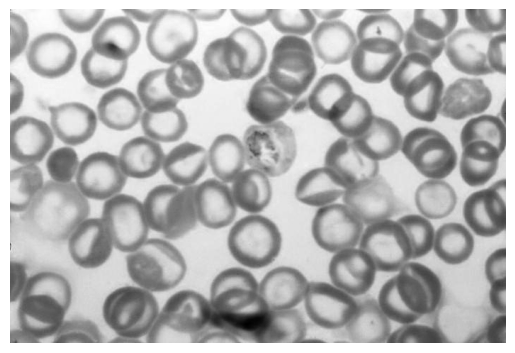

In [34]:
plt.imshow(gray, cmap='gray')
plt.axis('off')
plt.show()

### Blur

In [35]:
k = 11
blur = process_blur(gray,k)

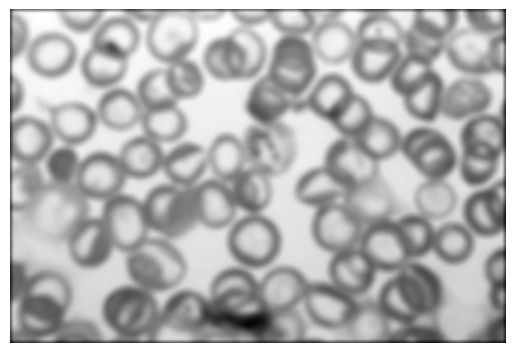

In [58]:
plt.imshow(blur, cmap='gray')
plt.axis('off')
plt.show()
plt.imsave('blurteste.png', blur)

### Limiarização Fixa

In [37]:
l = 120
lim_fix = process_lim_fix(gray,l)

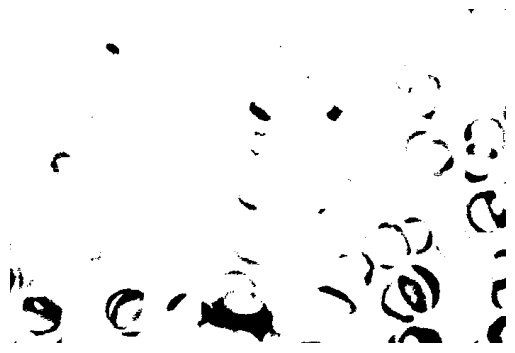

In [38]:
plt.imshow(lim_fix, cmap='gray')
plt.axis('off')
plt.show()

### Limiarização Adaptativa

In [39]:
k = 7
c = 10
lim_adapt = process_lim_adapt(gray,k, c)

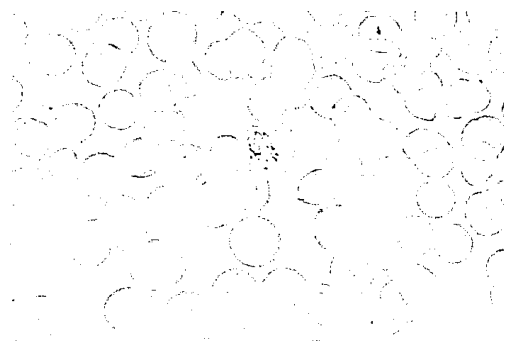

In [40]:
plt.imshow(lim_adapt, cmap='gray')
plt.axis('off')
plt.show()

### Limiarização de Otsu

In [41]:
lim_otsu = process_lim_otsu(gray)

<Figure size 640x480 with 0 Axes>

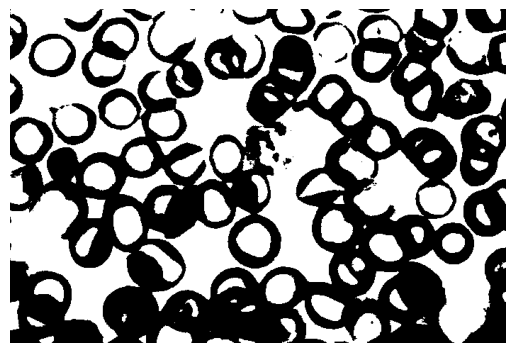

In [42]:
plt.imshow(lim_otsu, cmap='gray')
plt.axis('off')
plt.show()

### Erosão

Imagem Cinza -> Threshold -> Erosao

In [43]:
k = 9
er = process_erode_image(lim_otsu, k)

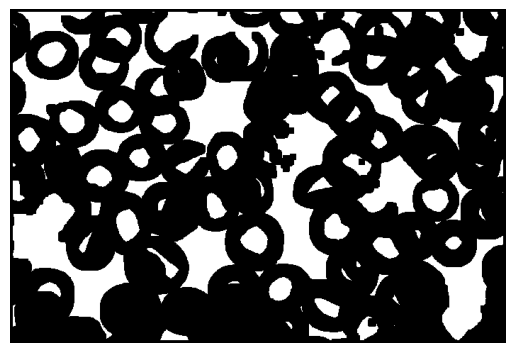

In [44]:
plt.imshow(er, cmap='gray')
plt.axis('off')
plt.show()

### Dilatação

Imagem Cinza -> Threshold -> Dilatação

In [45]:
k=5
dil = process_dilate_image(lim_otsu, k)

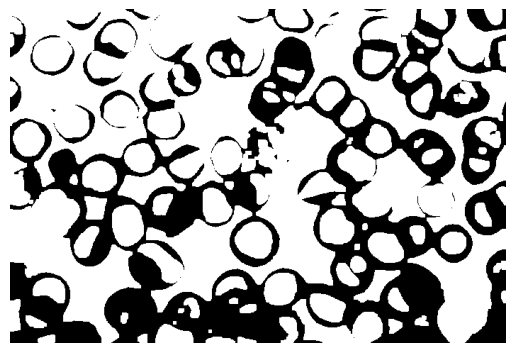

In [46]:
plt.imshow(dil, cmap='gray')
plt.axis('off')
plt.show()

### Abertura

Imagem Cinza -> Threshold -> Erosao -> Dilatação -> Resultado


In [47]:
k = 3
abert = process_opening_image(lim_otsu, k)



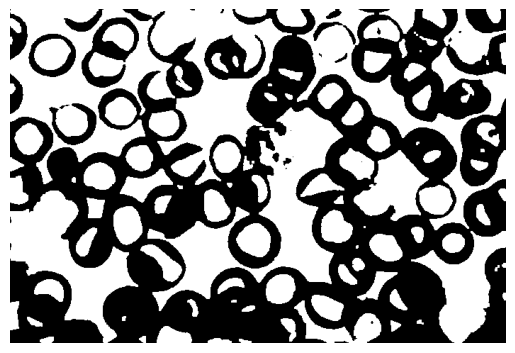

In [48]:
plt.imshow(abert, cmap='gray')
plt.axis('off')
plt.show()

### Fechamento

Imagem Cinza -> Threshold -> Dilatação -> Erosao ->  Resultado


In [49]:
k = 3
fech = process_closing_image(lim_otsu, k)

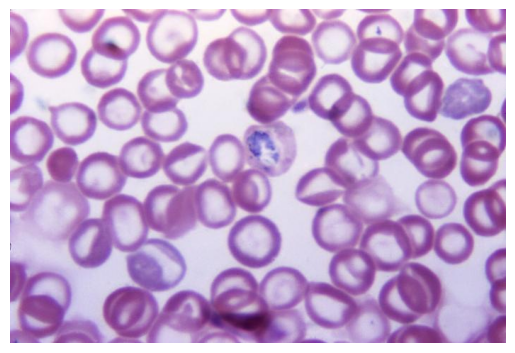

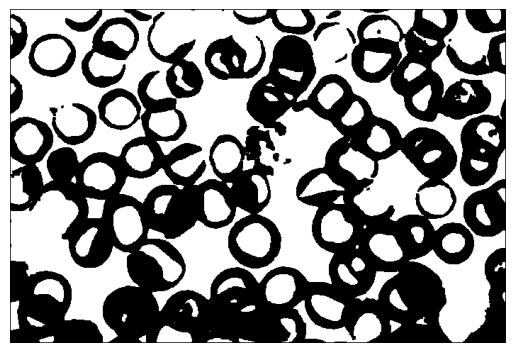

In [50]:
plt.imshow(input, cmap='gray')
plt.axis('off')
plt.show()


plt.imshow(fech, cmap='gray')
plt.axis('off')
plt.show()

### Gradiente Morfológico

Diferença entre Erosão e Dilatação

In [51]:
'''
1- imagem cinca
2- Threshold
3- Erosão
4- Dilatação
5- Diferença entre Erosão e Dilatação
6- Resultado
'''
k = 5
grad = process_grad_morf_image(lim_otsu, k)

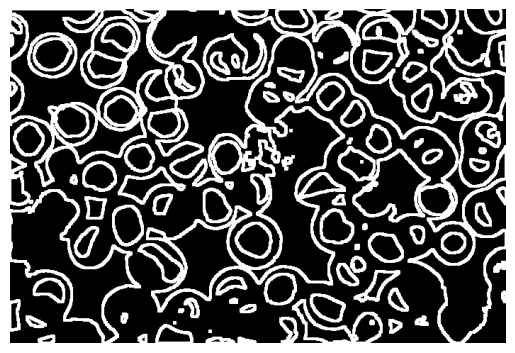

In [52]:
plt.imshow(grad, cmap='gray')
plt.axis('off')
plt.show()

### Cartola

Diferença entre Imagem de entrada e a Abertura

In [53]:
k = 71
cartola = process_cartol_image(lim_otsu,k)


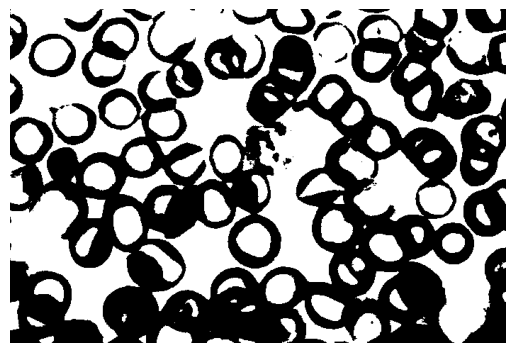

In [54]:
plt.imshow(cartola, cmap='gray')
plt.axis('off')
plt.show()

### Chapeu Preto

Diferença eentre a imagem de entrada e o Fechamento

In [55]:
k = 17
darkfilter = process_darkhat_image(lim_otsu, k)

/tmp/ipykernel_31591/2587772720.py:89: RuntimeWarning: overflow encountered in ubyte_scalars
  m_suporte[i][j] =int(dilat[i][j]-erode[i][j])


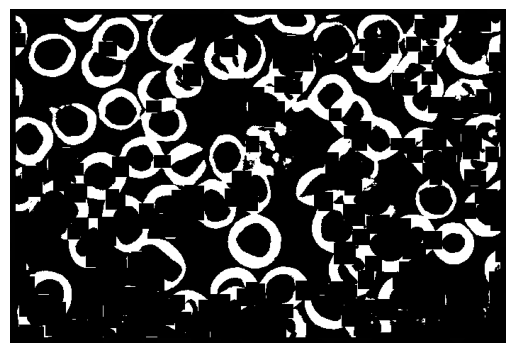

In [56]:
plt.imshow(darkfilter, cmap='gray')
plt.axis('off')
plt.show()